In [2]:
import os
from PIL import Image
from torchvision import transforms
from torchvision.transforms import functional as TF
import random
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
class RotationClassifier(nn.Module):
    def __init__(self):
        super(RotationClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(32 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, 360)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(-1, 32 * 32 * 32)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [9]:
import cv2
import numpy as np
import torch
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision.models as models
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RotationClassifier()

model.load_state_dict(torch.load('C:\\Users\\22597\\Documents\\GitHub\\boiling\\4rotation\\model\\rotationCNN1500epoch.pth'))

model.to(device)
model.eval()  # 设置模型为评估模式

def square_padding(img):
    width, height = img.size
    max_dim = max(width, height)
    new_img = Image.new('L', (max_dim, max_dim), color=255)
    left = (max_dim - width) // 2
    top = (max_dim - height) // 2
    new_img.paste(img, (left, top))
    plt.imshow(new_img, cmap='gray')  # 使用灰度色图，因为图像为灰度
    plt.axis('off')  # 关闭坐标轴
    plt.show()  # 显示图像
    return new_img

# 图片预处理
def set_non_white_to_black(image):
    """
    将非白色像素设置为黑色。
    :param image: PIL.Image对象
    :return: 修改后的PIL.Image对象
    """
    # 转换为NumPy数组以便进行像素操作
    np_image = np.array(image)
    # 找到非白色像素
    non_white_pixels = np_image != 255
    # 将这些像素设置为黑色
    np_image[non_white_pixels] = 0
    # 将NumPy数组转换回PIL.Image
    return Image.fromarray(np_image)

# 假设你的模型已经被加载并且已经在eval模式下
pre_model = RotationClassifier()
pre_model.load_state_dict(torch.load('C:\\Users\\22597\\Documents\\GitHub\\boiling\\4rotation\\model\\rotationCNN.pth'))
pre_model.eval()

# 定义一个新的Lambda变换，它使用你的模型来预测旋转角度，并旋转图像
def apply_rotation_correction(image):
    tensor_image = transforms.ToTensor()(image).unsqueeze_(0).to(device)
    
    # 使用模型预测旋转角度
    with torch.no_grad():
        output = pre_model(tensor_image)
        probabilities = torch.nn.functional.softmax(output[0], dim=0)
        predicted_angle = torch.argmax(probabilities).item()
    # 旋转图像
    rotated_image = image.rotate(-predicted_angle, expand=True)  # 注意旋转方向
    return rotated_image

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Lambda(square_padding),
    transforms.Lambda(set_non_white_to_black),
    transforms.Pad(7, fill=255),
    transforms.Resize((128, 128)),
    #transforms.Lambda(apply_rotation_correction),  # 添加你的模型旋转矫正
    #transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])



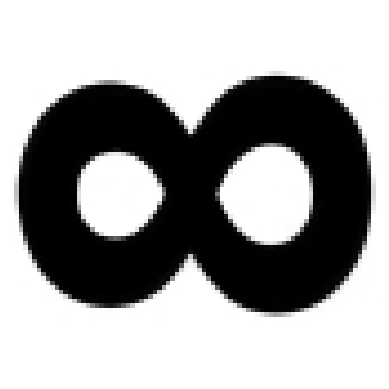

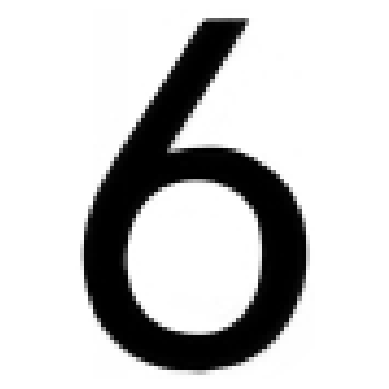

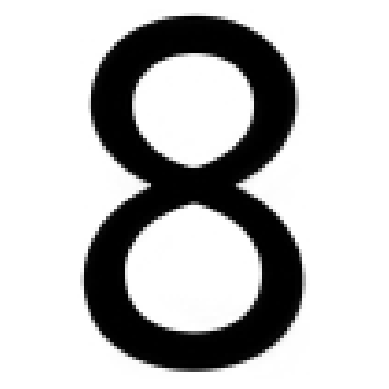

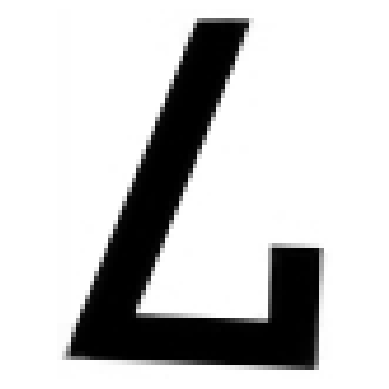

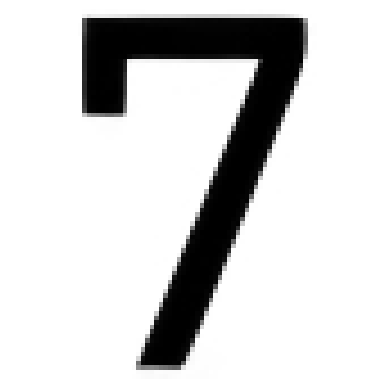

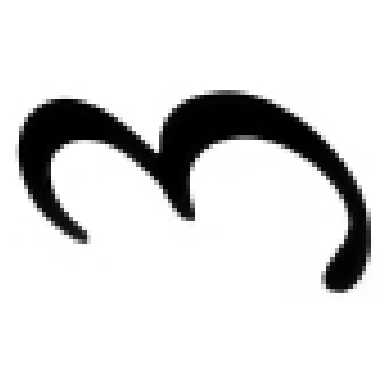

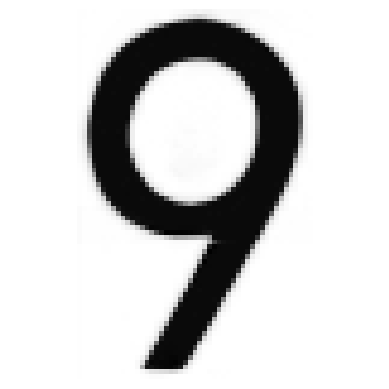

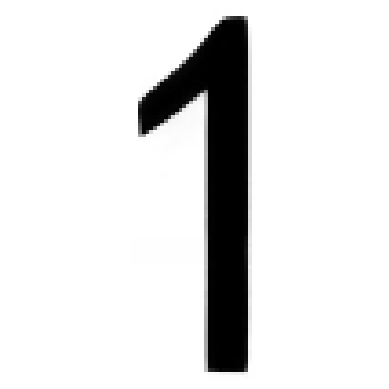

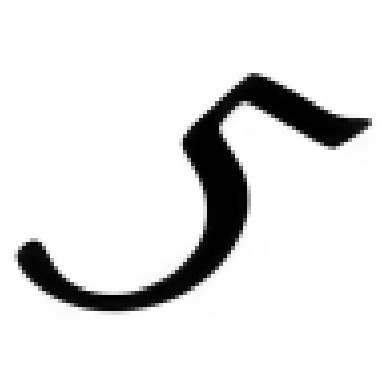

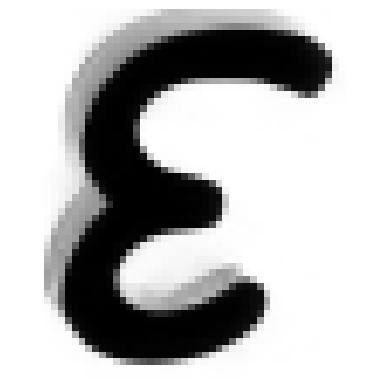

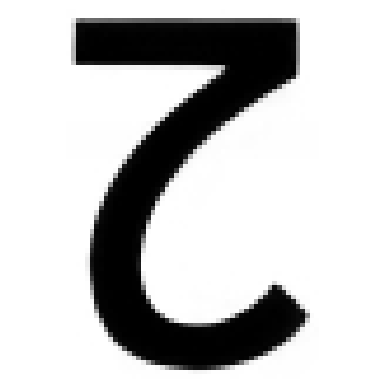

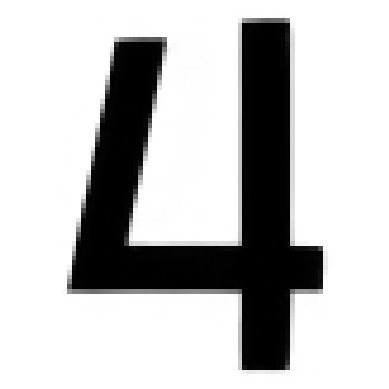

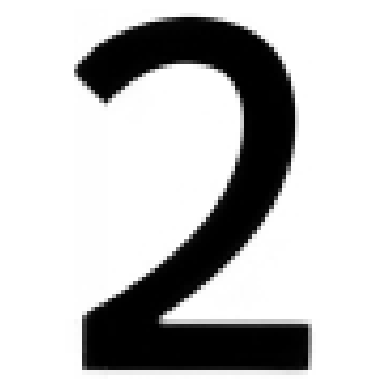

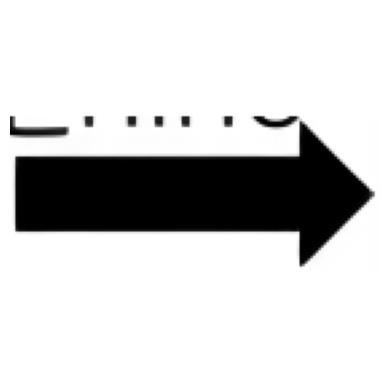

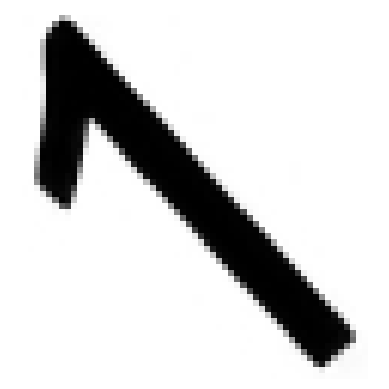

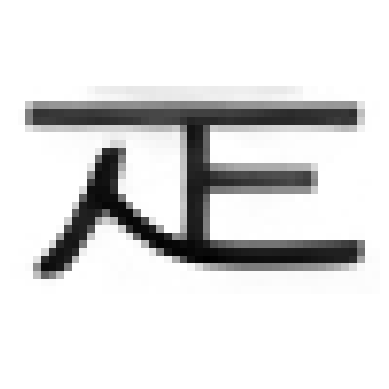

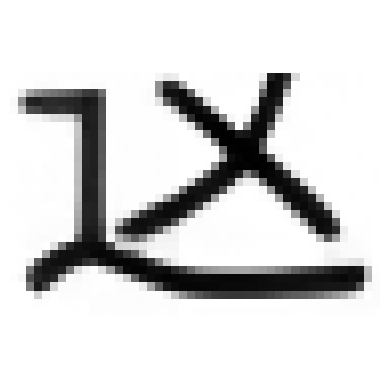

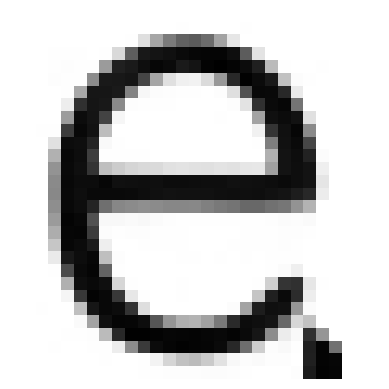

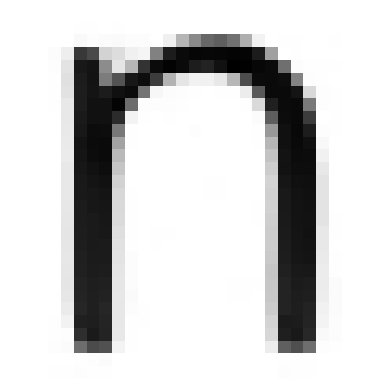

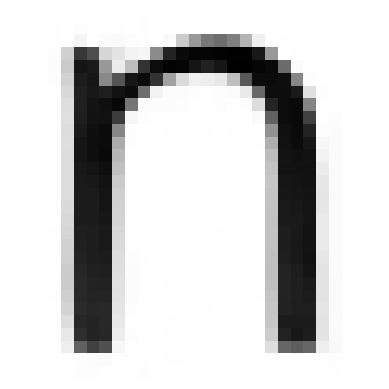

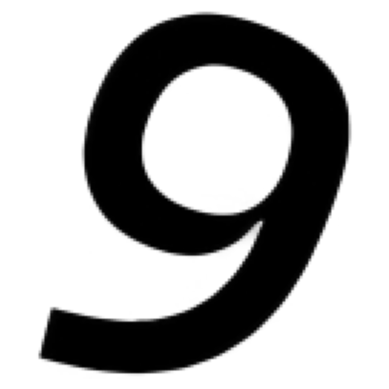

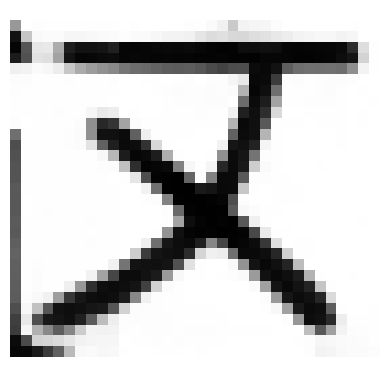

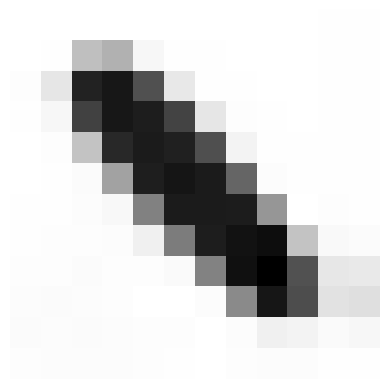

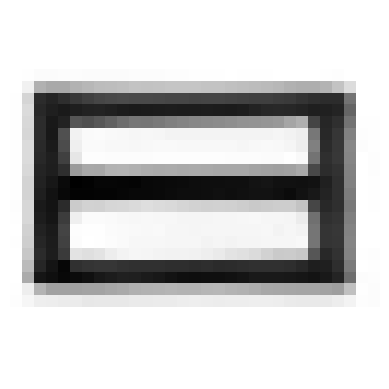

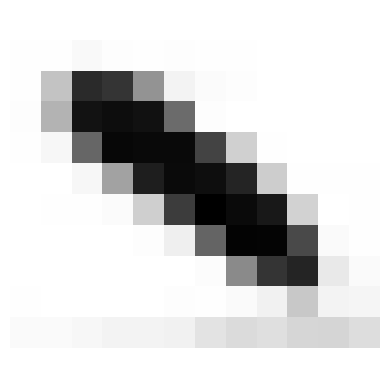

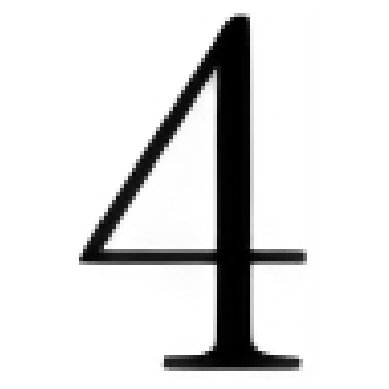

In [10]:
import torch.nn.functional as F

image = cv2.imread('C:\\Users\\22597\\Documents\\GitHub\\boiling\\B.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# 应用阈值处理以分离前景和背景
_, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# 寻找轮廓
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 遍历每一个轮廓
for contour in contours:
    # 获取边界框
    x, y, w, h = cv2.boundingRect(contour)
    # 忽略太小的边界框，可能是噪声

    x -= 2
    y -= 2
    w += 4
    h += 4

    if w < 10 or h < 10:
        continue

    # 提取ROI
    roi = gray[y:y+h, x:x+w]

    # 将ROI转换为PIL图像，以便使用PIL的变换
    roi_pil = Image.fromarray(roi)
    
    # 将ROI转换为模型可以接受的格式
    roi_processed = transform(roi_pil).unsqueeze_(0).to(device)

    # 前向传播
    with torch.no_grad():
        output = model(roi_processed)
        _, predicted = torch.max(output, 1)
        pred = predicted.item()

    # 绘制矩形和标签
    cv2.rectangle(image, (x, y), (x+w, y+h), (0, 0, 255), 2)
    cv2.putText(image, str(pred), (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

# 显示结果
cv2.imshow('Result', image)
cv2.imwrite('outputBBB.jpg', image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader, SubsetRandomSampler
# from torchvision import datasets, transforms
# import numpy as np

# # 设定设备
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # 定义数据预处理
# data_transforms = transforms.Compose([
#     transforms.Resize((128, 128)),
#     transforms.Grayscale(num_output_channels=1),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5,), (0.5,))
# ])

# # 加载数据集
# dataset = datasets.ImageFolder(root='trainpic', transform=data_transforms)

# # 定义模型
# model = nn.Sequential(
#     nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
#     nn.ReLU(),
#     nn.MaxPool2d(kernel_size=2, stride=2),
#     nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
#     nn.ReLU(),
#     nn.MaxPool2d(kernel_size=2, stride=2),
#     nn.Flatten(),
#     nn.Linear(64 * 32 * 32, 128),
#     nn.ReLU(),
#     nn.Linear(128, 10),
#     nn.LogSoftmax(dim=1)
# ).to(device)

# # 定义损失函数和优化器
# criterion = nn.NLLLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # 训练模型
# num_epochs = 10
# for epoch in range(num_epochs):
#     # 每个epoch重新划分训练集和验证集
#     indices = list(range(len(dataset)))
#     split = int(np.floor(0.25 * len(dataset)))  # 25%用于验证
#     np.random.shuffle(indices)
    
#     train_indices, val_indices = indices[split:], indices[:split]
    
#     # 创建Sampler
#     train_sampler = SubsetRandomSampler(train_indices)
#     val_sampler = SubsetRandomSampler(val_indices)
    
#     # 创建DataLoader
#     trainloader = DataLoader(dataset, batch_size=64, sampler=train_sampler)
#     valloader = DataLoader(dataset, batch_size=64, sampler=val_sampler)

#     model.train()  # 设置模型为训练模式
#     running_loss = 0.0
#     for i, data in enumerate(trainloader, 0):
#         inputs, labels = data
#         inputs, labels = inputs.to(device), labels.to(device)

#         optimizer.zero_grad()

#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()

#     # 在验证集上测试模型
#     model.eval()  # 设置模型为评估模式
#     correct = 0
#     total = 0
#     with torch.no_grad():  # 不需要计算梯度
#         for data in valloader:
#             images, labels = data
#             images, labels = images.to(device), labels.to(device)
#             outputs = model(images)
#             _, predicted = torch.max(outputs.data, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()

#     accuracy = 100 * correct / total
#     print(f'Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}, Validation Accuracy: {accuracy}%')

# print('Finished Training')

# # 保存模型
# torch.save(model.state_dict(), 'digit_recognition_model_02.pth')